# KdV equation

In [1]:
import sys
import os
sys.path.append("./src")

In [2]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *

### Setup

In [3]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [4]:
# Problem and training data

problem_data = ProblemData(name='kdv', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=4, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           exact_sol=exactKdVTwoSol, # exact solution
                           N=2048, # number of spatial points
                           dt=1.0, # time step (not needed here, we use an adaptive step with RK45)
                          )

training_data = TrainingData(m=10, # number of neurons per layer
                             l=1, # number of layers
                             batch_size=5000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                             # scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                             #                                 transition_steps=1000, transition_begin=1000) # learning rate scheduler
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                            )

In [5]:
# Neural network

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])
print(net)

ShallowNetKdV(
    # attributes
    m = 10
    L = 60
)


### Initial fit

In [6]:
# Initial fit

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - exactKdVTwoSol(x_plot, 0)) / jnp.linalg.norm(exactKdVTwoSol(x_plot, 0))
    print("Relative error of the initial fit:", relative_error)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Relative error of the initial fit: 0.0059745763


### Time evolution

In [7]:
# Source term for the KdV equation

def rhs_kdv(theta_flat, x, t, u_fn):
    U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
    U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
    U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x

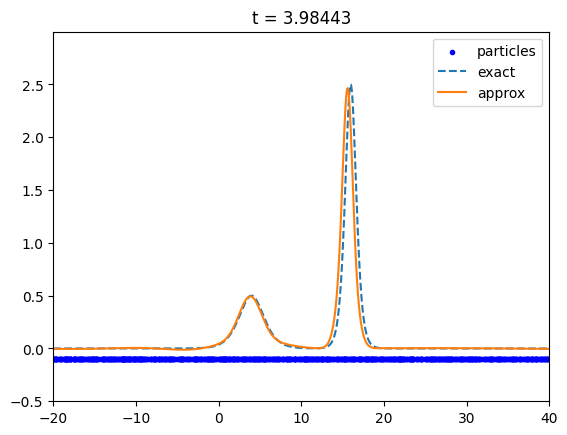

In [8]:
solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                  net=net, # neural network
                                                  problem_data=problem_data, # problem data
                                                  n=1000, # sample points
                                                  rhs=rhs_kdv, # problem RHS
                                                  x_init=None,
                                                  sampler='uniform',
                                                  scheme='rk45',
                                                  diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                 )

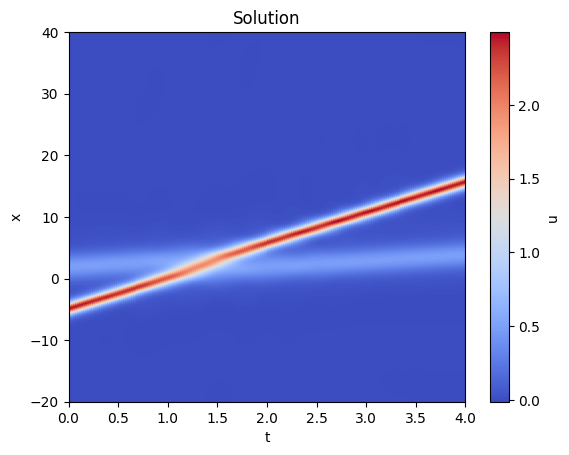

In [9]:
plot_solution(solution, timesteps, problem_data)

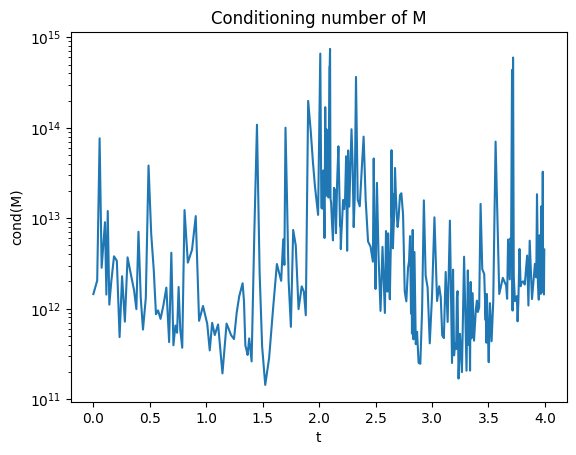

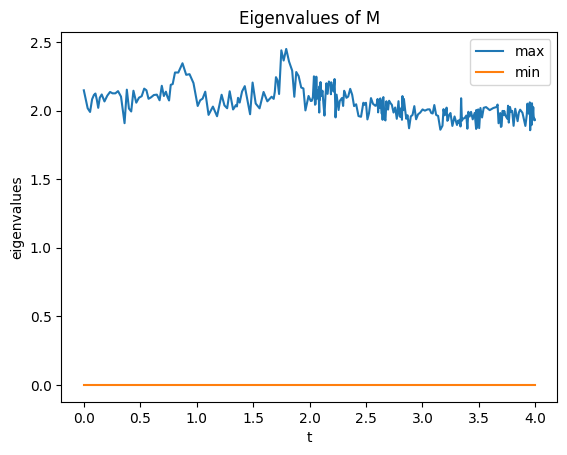

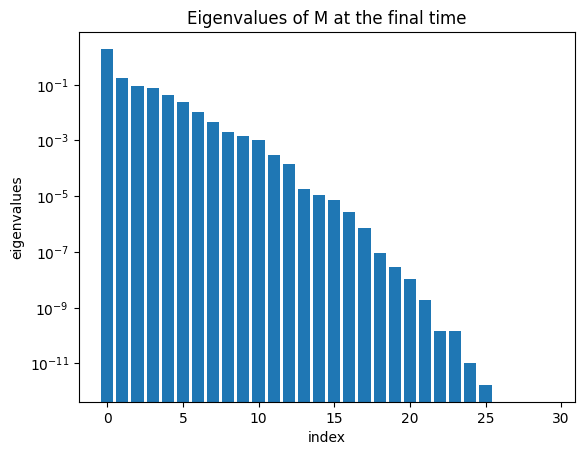

In [10]:
diagnostic.plot(timesteps)

### Conditioning number w.r.t. number of samples

In [ ]:
samples_list = [1000, 2000, 4000, 8000]
cond_list = []
max_eig_list = []
min_eig_list = []

for samples in samples_list:
    solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                      net=net, # neural network
                                                      problem_data=problem_data, # problem data
                                                      n=samples, # sample points
                                                      rhs=rhs_kdv, # problem RHS
                                                      x_init=None,
                                                      sampler='uniform',
                                                      scheme='rk45',
                                                      diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                      plot_on=False
                                                     )
    avg_cond, avg_max_eig, avg_min_eig = diagnostic.averaged()
    cond_list.append(avg_cond)
    max_eig_list.append(avg_max_eig)
    min_eig_list.append(avg_min_eig)

In [16]:
cond_list

[Array(8.8584973e+15, dtype=float32),
 Array(4.5463256e+13, dtype=float32),
 Array(1.8150517e+13, dtype=float32),
 Array(1.6666643e+13, dtype=float32)]

In [ ]:
# [Array(8.8584973e+15, dtype=float32),
#  Array(4.5463256e+13, dtype=float32),
#  Array(1.8150517e+13, dtype=float32),
#  Array(1.6666643e+13, dtype=float32)]

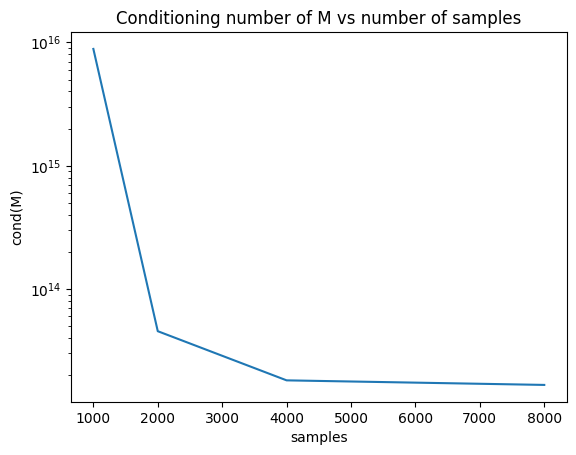

In [17]:
plt.semilogy(samples_list, cond_list)
plt.title('Conditioning number of M vs number of samples')
plt.xlabel('samples')
plt.ylabel('cond(M)')
plt.show()

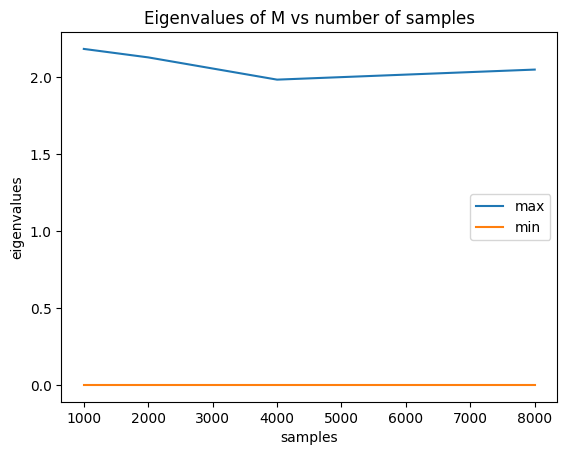

In [13]:
plt.plot(samples_list, max_eig_list)
plt.plot(samples_list, min_eig_list)
plt.title('Eigenvalues of M vs number of samples')
plt.xlabel('samples')
plt.ylabel('eigenvalues')
plt.legend(['max', 'min'])
plt.show()

### Conditioning number w.r.t. number of parameters

In [13]:
neurons = 25

In [14]:
# Set the training parameters to achieve an initial error of around 0.005
# m = 10 (baseline): batch_size = 5000, epochs = 10000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)
# m = 15: batch_size = 5000, epochs = 10000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)
# m = 20: batch_size = 1000, epochs = 10000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)
# m = 25: batch_size = 1000, epochs = 7000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)

In [15]:
training_data = TrainingData(m=neurons, # number of neurons per layer
                             l=1, # number of layers
                             batch_size=500, # batch size
                             epochs=5000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                            )

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_' + str(neurons) + '.npy', theta)

In [ ]:
neurons_list = [10, 15, 20, 25]
cond_list = []
max_eig_list = []
min_eig_list = []

for neurons in neurons_list:

    print(f'Running model with {neurons} neurons...')

    if neurons == 10:
        theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item() # baseline
    else:
        theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_' + str(neurons) + '.npy', allow_pickle=True).item()

    net = ShallowNetKdV(neurons, problem_data.domain[1] - problem_data.domain[0])
    
    solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                      net=net, # neural network
                                                      problem_data=problem_data, # problem data
                                                      n=1000, # sample points
                                                      rhs=rhs_kdv, # problem RHS
                                                      x_init=None,
                                                      sampler='uniform',
                                                      scheme='rk45',
                                                      diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                      plot_on=False
                                                     )

    avg_cond, avg_max_eig, avg_min_eig = diagnostic.averaged()
    cond_list.append(avg_cond)
    max_eig_list.append(avg_max_eig)
    min_eig_list.append(avg_min_eig)

In [20]:
cond_list

[Array(2.333777e+13, dtype=float32),
 Array(7.452565e+14, dtype=float32),
 Array(inf, dtype=float32),
 Array(9.856994e+20, dtype=float32)]

In [ ]:
plt.semilogy(neurons_list, cond_list)
plt.title('Conditioning number of M vs number of neurons')
plt.xlabel('m')
plt.ylabel('cond(M)')
plt.show()

In [ ]:
plt.plot(neurons_list, max_eig_list)
plt.plot(neurons_list, min_eig_list)
plt.title('Eigenvalues of M vs number of neurons')
plt.xlabel('m')
plt.ylabel('eigenvalues')
plt.legend(['max', 'min'])
plt.show()

### Comparison with Neural Galerkin with adaptive measure

In [8]:
# Accept-reject to sample from the initial condition

from scipy.stats import norm, uniform
from numpy import random

def init_samples_kdv(n, max_it=1000, seed=0):

    random.seed(seed) # set seed for reproducibility

    def KdVWrapper(x):
        x = jnp.array([x])
        kdv = exactKdVTwoSol(x, 0)
        return kdv.squeeze()

    g = norm(loc=-5, scale=4.5) # proposal distribution
    C = 29 # scaling constant

    x = []

    for _ in range(n):
        it = 0
        while it < max_it:
            y = g.rvs() # sample from the Gaussian
            u = uniform.rvs() # sample from a uniform in [0, 1]
            if u <= KdVWrapper(y) / (C * g.pdf(y)):
                x.append(y)
                break
            it += 1
        if it >= max_it:
            raise Exception("AR did not converge.")

    return jnp.array(x)

In [9]:
# Built-in SciPy function to sample from the initial condition (DOES NOT WORK - ONLY FOR UNIMODAL DISTRIBUTIONS)

# from scipy.stats.sampling import TransformedDensityRejection

# def KdVWrapper(x):
#     x = jnp.array([x])
#     kdv = exactKdVTwoSol(x, 0)
#     return kdv.squeeze()

# dist = Distribution(pdf=KdVWrapper)
# rng = TransformedDensityRejection(dist, domain=(problem_data.domain[0], problem_data.domain[1]))
# rvs = rng.rvs(100)

# x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], 100)
# plt.plot(x_plot, exactKdVTwoSol(x_plot.reshape(-1, 1)))
# plt.plot(rvs, jnp.zeros(100))
# plt.show()

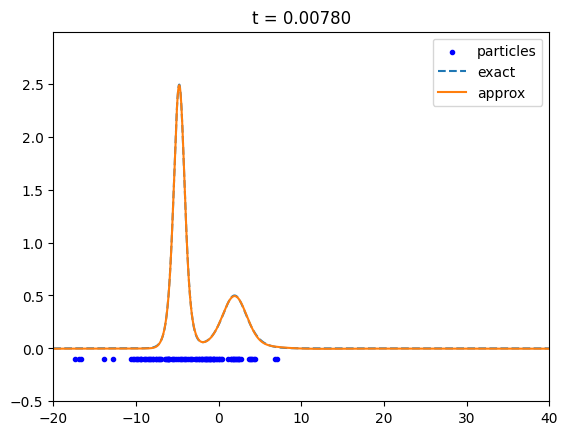

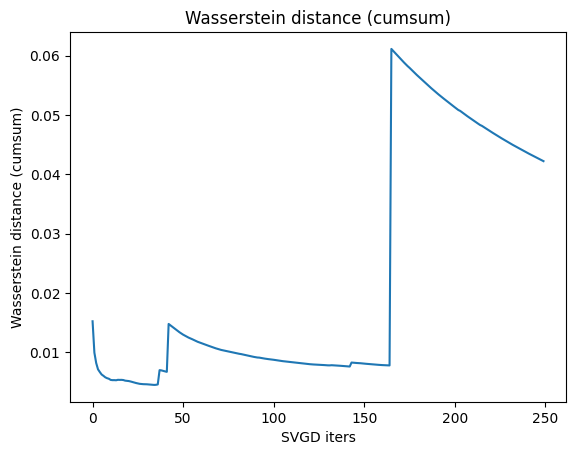

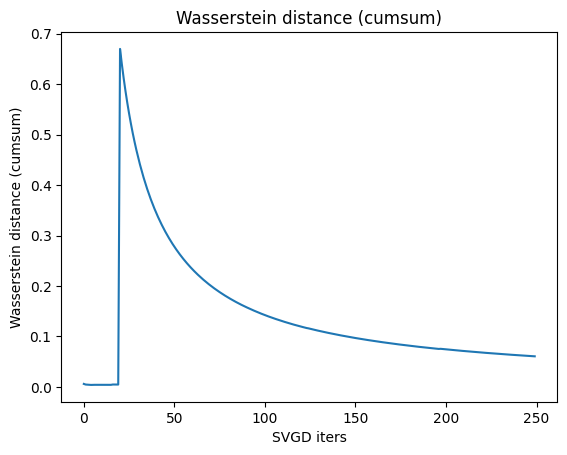

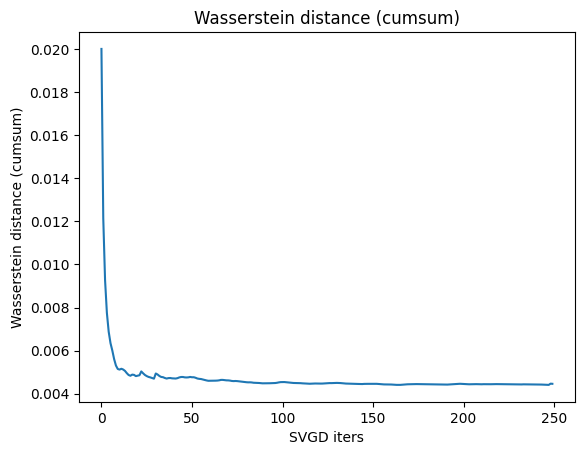

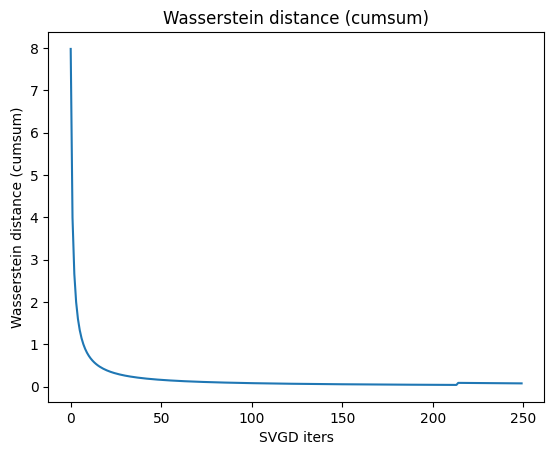

KeyboardInterrupt: 

In [9]:
# ORIGINAL SVGD

solution_adaptive, timesteps_adaptive, diagnostic_adaptive = neural_galerkin(theta=theta, # initial parameters
                                                                             net=net, # neural network
                                                                             problem_data=problem_data, # problem data
                                                                             n=100, # sample points
                                                                             rhs=rhs_kdv, # problem RHS
                                                                             x_init=init_samples_kdv(100).reshape(-1, 1), # particles
                                                                             sampler='svgd',
                                                                             scheme='rk45',
                                                                             diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                                            )

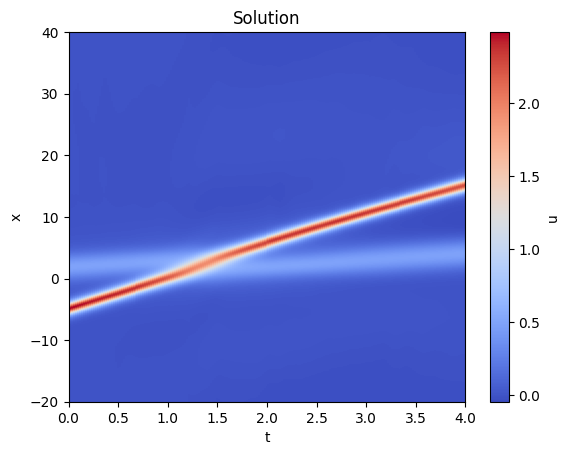

In [11]:
plot_solution(solution_adaptive, timesteps_adaptive, problem_data)

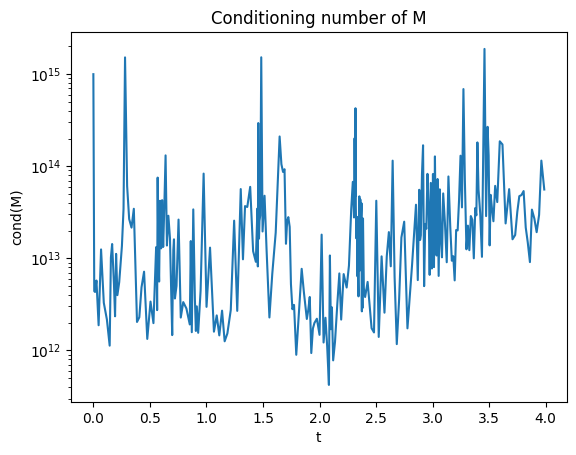

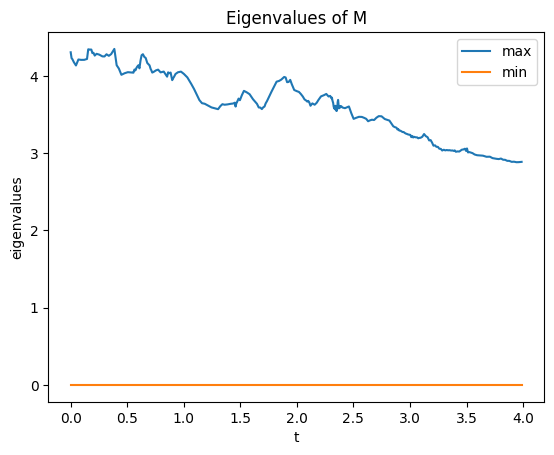

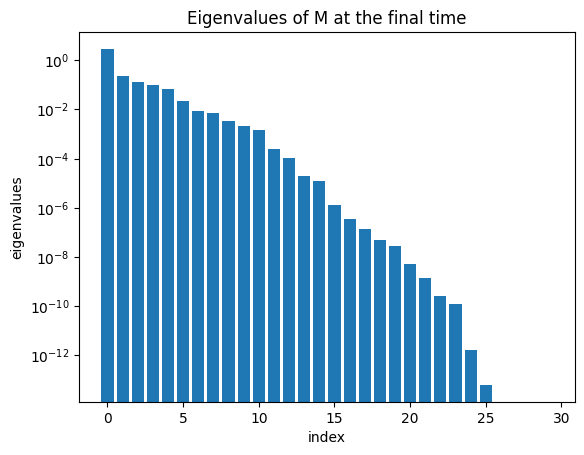

In [11]:
diagnostic_adaptive.plot(timesteps_adaptive)

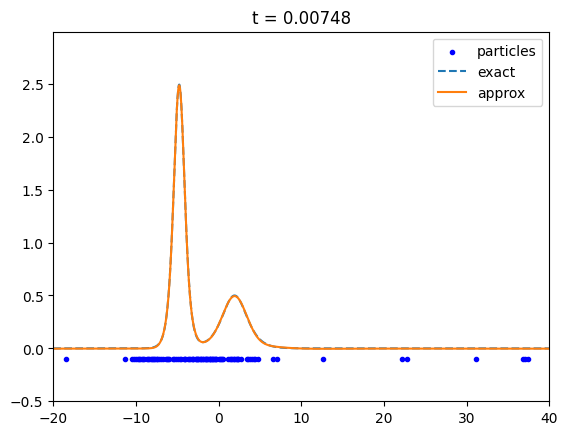

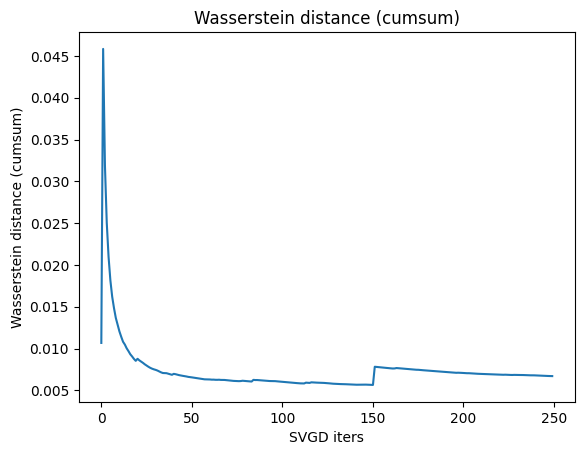

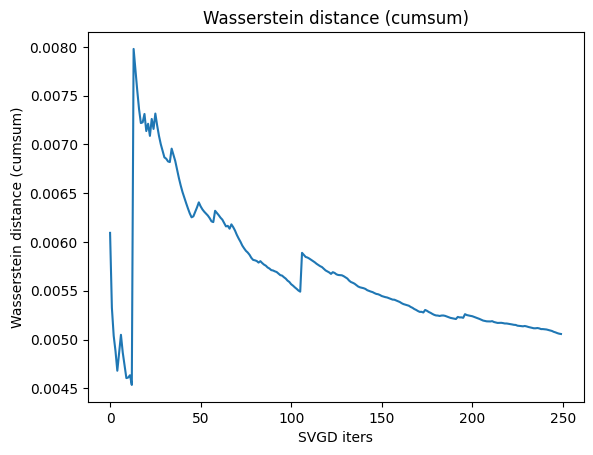

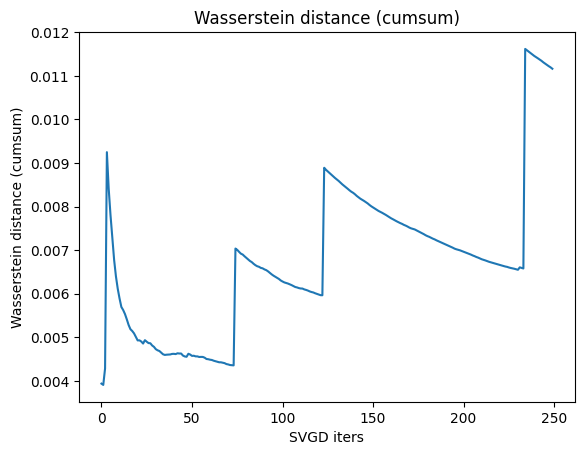

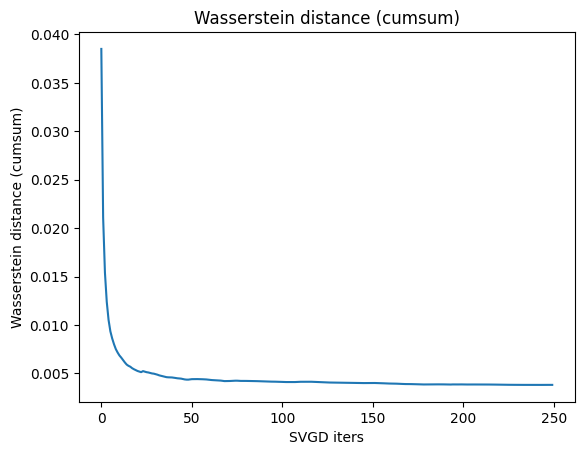

KeyboardInterrupt: 

In [10]:
# CORRECTED SVGD

solution_adaptive, timesteps_adaptive, diagnostic_adaptive = neural_galerkin(theta=theta, # initial parameters
                                                                             net=net, # neural network
                                                                             problem_data=problem_data, # problem data
                                                                             n=100, # sample points
                                                                             rhs=rhs_kdv, # problem RHS
                                                                             x_init=init_samples_kdv(100).reshape(-1, 1), # particles
                                                                             sampler='svgd_corrected',
                                                                             scheme='rk45',
                                                                             diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                                            )

### Conditioning number w.r.t. number of samples

In [ ]:
# samples_list_adaptive = [100, 200, 400, 800]
# cond_list_adaptive = []
# max_eig_list_adaptive = []
# min_eig_list_adaptive = []

# for samples in samples_list_adaptive:
#     solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
#                                                       net=net, # neural network
#                                                       problem_data=problem_data, # problem data
#                                                       n=samples, # sample points
#                                                       rhs=rhs_kdv, # problem RHS
#                                                       x_init=None,
#                                                       sampler='uniform',
#                                                       scheme='rk45',
#                                                       diagnostic_on=True, # save conditioning number and singular values of the mass matrix
#                                                       plot_on=False
#                                                      )
#     avg_cond, avg_max_eig, avg_min_eig = diagnostic.averaged()
#     cond_list_adaptive.append(avg_cond)
#     max_eig_list_adaptive.append(avg_max_eig)
#     min_eig_list_adaptive.append(avg_min_eig)